In [1]:
import time
import os
import joblib
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Ridge
#from sklearn.exceptions import UserWarning
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
filepath = 'bitcoin.csv'
data = pd.read_csv(os.path.join('./data', filepath))
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2010-07-18,0.0,0.1,0.1,0.1,75,USD
1,2010-07-19,0.1,0.1,0.1,0.1,574,USD
2,2010-07-20,0.1,0.1,0.1,0.1,262,USD
3,2010-07-21,0.1,0.1,0.1,0.1,575,USD
4,2010-07-22,0.1,0.1,0.1,0.1,2160,USD


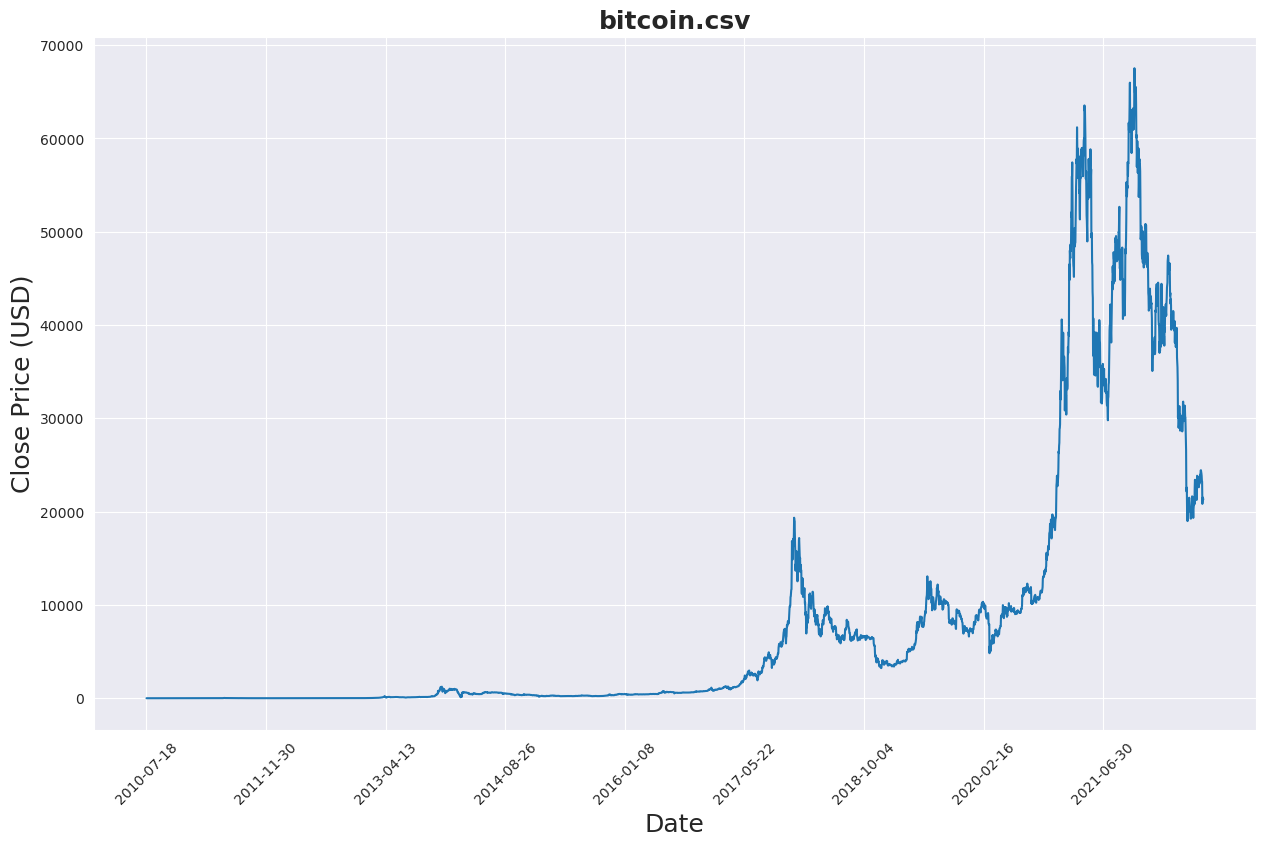

In [3]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title(filepath,fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [4]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4420 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    lookback+=1
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train[:,:,0], y_train, x_test[:,:,0], y_test]

In [7]:
def get_train_test_data(data, sequence: int=20, verbose=True, poly_degree=1):
    x_train, y_train, x_test, y_test = split_data(data, sequence)
    if poly_degree > 1:
        poly = PolynomialFeatures(poly_degree)
        x_train = poly.fit_transform(x_train)
        x_test  = poly.fit_transform(x_test)
    if verbose:
        print('x_train.shape = ',x_train.shape)
        print('y_train.shape = ',y_train.shape)
        print('x_test.shape = ',x_test.shape)
        print('y_test.shape = ',y_test.shape)
    return x_train, y_train, x_test, y_test

In [8]:
x,y,_,_ = get_train_test_data(price, 20)

x_train.shape =  (3519, 20)
y_train.shape =  (3519, 1)
x_test.shape =  (880, 20)
y_test.shape =  (880, 1)


In [9]:
def ablation_study(model, data, sequence_len, search_params, poly_degree):
    x_train, y_train, x_test, y_test = get_train_test_data(data, sequence_len, False, poly_degree=poly_degree)
    clf = GridSearchCV(model, search_params)
    clf.fit(x_train, y_train.ravel())
    return clf

In [10]:
ridge_reg = Ridge(max_iter=10000)

params = {
    'alpha': (0, 0.01, 0.1, 0.5, 1, 2, 5, 10, 100, 1000),
    #'solver': ('svd', 'cholesky', 'sparse_cg', 'lsqr'),
    }

In [11]:
clfs = []

for seq_len in [1, 2, 5, 10, 15, 20, 25]:
    print(seq_len)
    for degree in [1, 2, 5]:
        print('.', end='')
        clf = ablation_study(ridge_reg, price, seq_len, params, degree)
        clfs.append(clf)
    print()

1
...


2
...
5
...
10
...
15
...
20
...
25
...


In [21]:
seq = [1, 2, 5, 10, 15, 20, 25]
deg = [1, 2, 5]

for i in range(len([1, 2, 5, 10, 15, 20, 25])):
    for j in range(3):
        s = seq[i]
        d = deg[j]
        joblib.dump(clfs[len(deg)*i+j], 'models/lr/gs_'+str(s)+'seq_'+str(d)+'deg.pkl')

In [22]:
for i in range(len(seq)):
    for j in range(len(deg)):
        m = clfs[len(deg)*i+j]
        print(seq[i], ',', deg[j], ':', m.n_features_in_)

1 , 1 : 1
1 , 2 : 3
1 , 5 : 6
2 , 1 : 2
2 , 2 : 6
2 , 5 : 21
5 , 1 : 5
5 , 2 : 21
5 , 5 : 252
10 , 1 : 10
10 , 2 : 66
10 , 5 : 3003
15 , 1 : 15
15 , 2 : 136
15 , 5 : 15504
20 , 1 : 20
20 , 2 : 231
20 , 5 : 53130
25 , 1 : 25
25 , 2 : 351
25 , 5 : 142506
